# 1. Requirements

In [3]:
# !pip install "git+https://github.com/facebookresearch/pytorch3d.git"
!pip install antspyx
#!pip install torchio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 7.7 MB/s eta 0:00:00


## 1.2. Import modules

In [4]:
import ants
import zipfile
import numpy as np
import nibabel as nib
import os,glob,cv2,re,json,numbers
import pylab as plt
import pandas as pd
from pathlib import *
from scipy import ndimage
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.layers import BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Dense, Flatten, Input

# 2. Preprocessing

# 2.1. File Extraction

In [5]:
with zipfile.ZipFile("/content/drive/MyDrive/Parkinsons.zip","r") as zip_ref:
    zip_ref.extractall("/content/drive/MyDrive")

In [6]:
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    return scan
def normalize(image_arr):
    mean = np.mean(image_arr)
    std = np.std(image_arr)
    normalized_arr = (image_arr - mean) / std
    return normalized_arr
def resize_volume(img):
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    img = ndimage.rotate(img, 90, reshape=False)
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img
def apply_n4_bias_field_correction(img):
    img = ants.from_numpy(img)
    mask = ants.get_mask(img)
    img = ants.n4_bias_field_correction(img,mask= mask, rescale_intensities=True, shrink_factor=2, convergence={'iters': [50, 50, 30, 20], 'tol': 1e-07}, spline_param=None, return_bias_field=False, verbose=False, weight_mask=None)
    img = img.numpy()
    return img

def process_scan(path):
    volume = read_nifti_file(path)
    normalized_volume = normalize(volume)
    resized_volume = resize_volume(normalized_volume)
    bias_corrected_volume = apply_n4_bias_field_correction(resized_volume)
    return bias_corrected_volume

## 2.2. Processing

In [7]:
glob_path_control = glob.glob(r"/content/drive/MyDrive/Parkinsons/sub-control*.nii.gz")
glob_path_patient = glob.glob(r"/content/drive/MyDrive/Parkinsons/sub-patient*.nii.gz")

control_data = np.array([process_scan(path) for path in glob_path_control])
patient_data = np.array([process_scan(path) for path in glob_path_patient])


control_labels = np.array([1 for _ in range(len(control_data))])
patient_labels = np.array([0 for _ in range(len(patient_data))])


X = np.concatenate((control_data, patient_data), axis=0)
print("Dataset Shape : ", X.shape)
Y = np.concatenate((control_labels, patient_labels), axis=0)
print("Label Shape : ", Y.shape)

Dataset Shape :  (83, 128, 128, 64)
Label Shape :  (83,)


## 2.3. Train-Test Dataset

In [8]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Assuming Y has two classes
Y = to_categorical(Y, num_classes=2)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

print("X_train : ", x_train.shape)
print("X_test : ", x_test.shape)
print("Y_train : ", y_train.shape)
print("Y_test : ", y_test.shape)

X_train :  (66, 128, 128, 64)
X_test :  (17, 128, 128, 64)
Y_train :  (66, 2)
Y_test :  (17, 2)


# 3. Augmentation

In [9]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume = tf.cast(volume, dtype=tf.float32)  # Explicitly cast to float32
        volume = tf.clip_by_value(volume, 0.0, 1.0)
        return volume


    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume

@tf.function
def random_flip(volume):
    if random.choice([True, False]):
        volume = tf.image.flip_left_right(volume)
    if random.choice([True, False]):
        volume = tf.image.flip_up_down(volume)
    return volume




@tf.function
def random_brightness_contrast(volume):
    volume = tf.image.random_brightness(volume, max_delta=0.2)
    volume = tf.image.random_contrast(volume, lower=0.8, upper=1.2)
    return volume



def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    augmented_volume = rotate(volume)
    augmented_volume = random_flip(augmented_volume)
    augmented_volume = random_brightness_contrast(augmented_volume)

    # Augmented volume
    augmented_volume = tf.expand_dims(augmented_volume, axis=3)

    return augmented_volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    # Original volume without extra channel


    # Augmented volume
    augmented_volume = tf.expand_dims(volume, axis=3)

    return augmented_volume, label

## 3.2. Dataloader

In [10]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

batch_size = 2
# Augment the on the fly during training.
# this will be ultimately be fed into the model inshaAllah
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_test))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

## 3.3. Visualizing Augmented Data

Dimension of the MRI scan is: (128, 128, 64, 1)


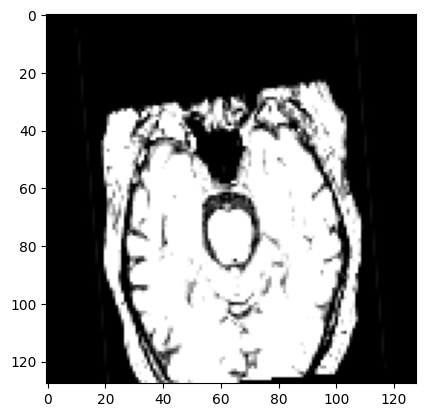

In [11]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the MRI scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

# 4. Models

## 4.1. Resnet 18

### 4.1.1. Architecture

In [ ]:
from tensorflow.keras import layers, models
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv3D(filters1, (1, 1, 1), name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, (1, 1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2, 2)):
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.Conv3D(filters1, (1, 1, 1), strides=strides, name=conv_name_base + '2a')(input_tensor)
    x = layers.BatchNormalization(name=bn_name_base + '2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, kernel_size, padding='same', name=conv_name_base + '2b')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, (1, 1, 1), name=conv_name_base + '2c')(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)

    shortcut = layers.Conv3D(filters3, (1, 1, 1), strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_resnet18_3d(input_shape=(32, 32, 32, 1), num_classes=2):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = layers.ZeroPadding3D(padding=(3, 3, 3))(input_tensor)
    x = layers.Conv3D(64, (7, 7, 7), strides=(2, 2, 2), name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding3D(padding=(1, 1, 1))(x)
    x = layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = layers.GlobalAveragePooling3D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc')(x)

    model = models.Model(input_tensor, x, name='resnet18_3d')
    return model
model = build_resnet18_3d(input_shape=(128, 128, 64, 1), num_classes=2)
model.summary

<bound method Model.summary of <keras.src.engine.functional.Functional object at 0x78aefae4f1c0>>

### 4.1.2. Model Compile

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50)

# Train the model, doing validation at the end of each epoch
epochs = 250
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

### 4.1.3. Result Visualization

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Calculate average accuracy

train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
print(max(val_accuracy))
average_train_accuracy = sum(train_accuracy) / len(train_accuracy)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)

print("Resnet 34")
print(f'Average Training Accuracy: {average_train_accuracy}')
print(f'Average Validation Accuracy: {average_val_accuracy}')

## 4.2. ResNet 34

### 4.2.1 Architecture

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv3D(filters1, (1, 1, 1), name=f'{conv_name_base}2a')(input_tensor)
    x = layers.BatchNormalization(name=f'{bn_name_base}2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, kernel_size, padding='same', name=f'{conv_name_base}2b')(x)
    x = layers.BatchNormalization(name=f'{bn_name_base}2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, (1, 1, 1), name=f'{conv_name_base}2c')(x)
    x = layers.BatchNormalization(name=f'{bn_name_base}2c')(x)

    x = layers.add([x, input_tensor])
    x = layers.Activation('relu')(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2, 2)):
    filters1, filters2, filters3 = filters

    conv_name_base = f'res{stage}{block}_branch'
    bn_name_base = f'bn{stage}{block}_branch'

    x = layers.Conv3D(filters1, (1, 1, 1), strides=strides, name=f'{conv_name_base}2a')(input_tensor)
    x = layers.BatchNormalization(name=f'{bn_name_base}2a')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters2, kernel_size, padding='same', name=f'{conv_name_base}2b')(x)
    x = layers.BatchNormalization(name=f'{bn_name_base}2b')(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv3D(filters3, (1, 1, 1), name=f'{conv_name_base}2c')(x)
    x = layers.BatchNormalization(name=f'{bn_name_base}2c')(x)

    shortcut = layers.Conv3D(filters3, (1, 1, 1), strides=strides, name=f'{conv_name_base}1')(input_tensor)
    shortcut = layers.BatchNormalization(name=f'{bn_name_base}1')(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_resnet34_3d(input_shape=(32, 32, 32, 1), num_classes=2):
    input_tensor = tf.keras.Input(shape=input_shape)

    x = layers.ZeroPadding3D(padding=(3, 3, 3))(input_tensor)
    x = layers.Conv3D(64, (7, 7, 7), strides=(2, 2, 2), name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding3D(padding=(1, 1, 1))(x)
    x = layers.MaxPooling3D((3, 3, 3), strides=(2, 2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='d')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = layers.GlobalAveragePooling3D(name='avg_pool')(x)
    x = layers.Dense(num_classes, activation='softmax', name='fc')(x)

    model = models.Model(input_tensor, x, name='resnet34_3d')
    return model
model2 = build_resnet34_3d(input_shape=(128, 128, 64, 1), num_classes=2)
model2.summary()

### 4.2.2. Model Compile

In [ ]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50)

# Train the model, doing validation at the end of each epoch
epochs = 150
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

### 4.2.3. Result

In [ ]:
# Calculate average accuracy

train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
print(max(val_accuracy))
average_train_accuracy = sum(train_accuracy) / len(train_accuracy)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)

print("Resnet 34")
print(f'Average Training Accuracy: {average_train_accuracy}')
print(f'Average Validation Accuracy: {average_val_accuracy}')

In [ ]:

import matplotlib.pyplot as plt
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## ResNet with Attention mechanism

### Model

In [13]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, BatchNormalization, ReLU, Add, GlobalAveragePooling3D, Dense

def residual_block(x, filters, kernel_size=3, strides=1, use_attention=True):
    # Convolutional layers
    residual = x
    x = Conv3D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Attention mechanism (if enabled)
    if use_attention:
        x = attention_block(x)

    x = Conv3D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)  # Adjust strides here
    x = BatchNormalization()(x)

    # Adjust dimensions of the residual tensor if needed
    if strides > 1:
        residual = Conv3D(filters, kernel_size=1, strides=strides, padding='same')(residual)

    # Residual connection
    x = Add()([residual, x])
    x = ReLU()(x)
    return x

def attention_block(x):
    # Attention mechanism (you can customize this based on your needs)
    channels = x.shape[-1]
    attention = Dense(channels, activation='softmax')(x)
    x = tf.multiply(x, attention)
    return x

def build_3d_resnet(input_shape, num_classes, use_attention=True):
    input_tensor = Input(shape=input_shape)

    # Initial Convolutional Layer
    x = Conv3D(64, kernel_size=7, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Residual blocks
    for _ in range(3):
        x = residual_block(x, filters=64, use_attention=use_attention)

    x = residual_block(x, filters=128, strides=2, use_attention=use_attention)
    for _ in range(3):
        x = residual_block(x, filters=128, use_attention=use_attention)

    x = residual_block(x, filters=256, strides=2, use_attention=use_attention)
    for _ in range(3):
        x = residual_block(x, filters=256, use_attention=use_attention)

    # Global Average Pooling and Dense layer for classification
    x = GlobalAveragePooling3D()(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=output_tensor)
    return model

# Example usage
input_shape = (128, 128, 64, 1)  # Adjust dimensions based on your 3D image size
num_classes = 2   # Binary classification
model = build_3d_resnet(input_shape, num_classes, use_attention=True)

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 64, 1)]    0         []                            
                                                                                                  
 conv3d_9 (Conv3D)           (None, 64, 64, 32, 64)       22016     ['input_2[0][0]']             
                                                                                                  
 batch_normalization_9 (Bat  (None, 64, 64, 32, 64)       256       ['conv3d_9[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 re_lu_8 (ReLU)              (None, 64, 64, 32, 64)       0         ['batch_normalization_9[0]

### Result

In [14]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=50)

# Train the model, doing validation at the end of each epoch
epochs = 250
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2
    #callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/250
33/33 - 72s - loss: 0.6707 - acc: 0.5909 - val_loss: 0.6983 - val_acc: 0.3529 - 72s/epoch - 2s/step
Epoch 2/250
33/33 - 36s - loss: 0.6966 - acc: 0.5909 - val_loss: 0.7015 - val_acc: 0.3529 - 36s/epoch - 1s/step
Epoch 3/250
33/33 - 36s - loss: 0.6890 - acc: 0.6061 - val_loss: 0.7020 - val_acc: 0.3529 - 36s/epoch - 1s/step
Epoch 4/250
33/33 - 36s - loss: 0.6687 - acc: 0.6212 - val_loss: 0.7168 - val_acc: 0.3529 - 36s/epoch - 1s/step
Epoch 5/250
33/33 - 35s - loss: 0.6745 - acc: 0.6212 - val_loss: 0.7280 - val_acc: 0.3529 - 35s/epoch - 1s/step
Epoch 6/250
33/33 - 35s - loss: 0.6685 - acc: 0.6212 - val_loss: 0.7331 - val_acc: 0.3529 - 35s/epoch - 1s/step
Epoch 7/250
33/33 - 35s - loss: 0.6528 - acc: 0.6364 - val_loss: 0.7425 - val_acc: 0.3529 - 35s/epoch - 1s/step
Epoch 8/250
33/33 - 36s - loss: 0.6558 - acc: 0.6818 - val_loss: 0.7559 - val_acc: 0.3529 - 36s/epoch - 1s/step
Epoch 9/250
33/33 - 35s - loss: 0.5839 - acc: 0.6515 - val_loss: 0.8214 - val_acc: 0.3529 - 35s/epoch - 

In [15]:
# Calculate average accuracy

train_accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
print(max(val_accuracy))
average_train_accuracy = sum(train_accuracy) / len(train_accuracy)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)

print("Resnet 34 with attention")
print(f'Average Training Accuracy: {average_train_accuracy}')
print(f'Average Validation Accuracy: {average_val_accuracy}')


0.7647058963775635
Resnet 34 with attention
Average Training Accuracy: 0.8710909080505371
Average Validation Accuracy: 0.5122353112101555


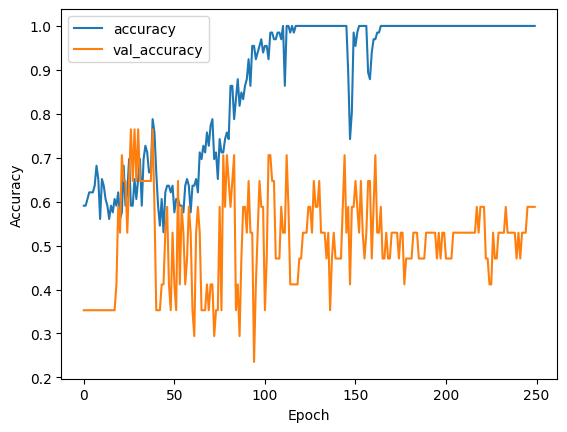

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()